In [1]:
from pathlib import Path
this_path = Path().resolve()

import torch
import numpy as np
from torch import nn, optim
from models.medicalnet.model import generate_model
from models.medicalnet.setting import get_def_args
import yaml
import pandas as pd
import torchio as tio
from dataset.ppmi_dataset import PPMIDataModule
from models.pl_model import Model
import matplotlib.pyplot as plt
import torchmetrics


### VQVAE

In [34]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
from typing import Optional, Tuple, List
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from torch import optim, nn
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import monai
import torchmetrics
import torchio as tio
import pytorch_lightning as pl
import numpy as np
import yaml
import kornia.losses as losses
from models.medicalnet.model import generate_model
from models.medicalnet.setting import get_def_args
# from utils.utils import get_pretrained_model
from pytorch_lightning.callbacks import Callback
import torchvision
from models.svae import spatialVAE
from GenerativeModels.generative.inferers import VQVAETransformerInferer
from GenerativeModels.generative.networks.nets import VQVAE, DecoderOnlyTransformer
from GenerativeModels.generative.utils.enums import OrderingType
from GenerativeModels.generative.utils.ordering import Ordering
this_path = Path().resolve()

In [2]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.max_memory_allocated()

0

In [3]:
from models.pl_model import GenerateReconstructions, Model_AE
from dataset.hmri_dataset import HMRIDataModule, HMRIControlsDataModule, HMRIPDDataModule

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

print('-------\n HPT-2\n-------')
# read the config file
with open('config/config_patches.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
cfg['dataset']['train_batch_size'] = 2
cfg['dataset']['val_batch_size'] = 2
augmentations = tio.Compose([])

with open('config/config_patches.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

data = HMRIControlsDataModule(md_df=md_df_hc,
                        root_dir=root_dir,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()

-------
 HPT-2
-------


In [4]:
# model = Model_AE(patch_size=cfg['dataset']['patch_size'],
#                      **cfg['model'])
vqvae_model = VQVAE(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_res_layers=2,
    downsample_parameters=((2, 3, 1, 1), (2, 3, 1, 1)),
    upsample_parameters=((2, 3, 1, 1, 1), (2, 3, 1, 1, 1)),
    num_channels=(96, 96),
    num_res_channels=(96, 96),
    num_embeddings=256,
    embedding_dim=32,
)
vqvae_model = vqvae_model.to(device)

torch.Size([4, 1, 128, 128, 128])


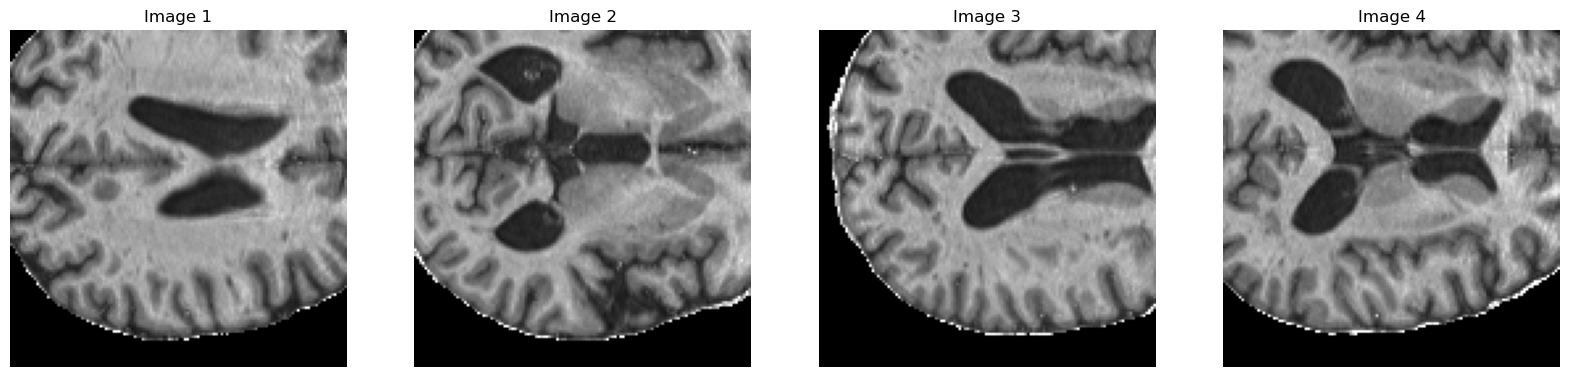

In [5]:
test_imgs = data.get_images(num=4, mode='train')
print(test_imgs.shape)
slice = 90
# display images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(test_imgs[i, 0, :, :, slice], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Image {i+1}')

In [12]:
# run the model
vqvae_model.eval()
with torch.no_grad():
    e_indices = vqvae_model.index_quantize(test_imgs.to(device))
    print(e_indices.shape)

torch.Size([4, 32, 32, 32])


In [31]:
(torch.ones((1, 1)) * vqvae_model.num_embeddings).long().size(1)

1

In [23]:
e_indices.reshape(e_indices.shape[0], -1).shape

torch.Size([4, 32768])

In [20]:
np.unique(e_indices[0].numpy(), return_counts=True)

(array([ 69, 173, 238]), array([21999, 10768,     1]))

In [11]:
with torch.no_grad():
    encodings = vqvae_model.encode(test_imgs.to(device))
    print(encodings.shape)

torch.Size([4, 32, 32, 32, 32])


In [21]:
encodings[0][:][0, 0 , 0]

tensor([-0.0144, -0.0085, -0.0069, -0.0065, -0.0040, -0.0013,  0.0039,  0.0121,
         0.0068,  0.0126,  0.0190,  0.0054,  0.0152,  0.0424,  0.0481,  0.0397,
         0.0298,  0.0232,  0.0028,  0.0200,  0.0496,  0.0193,  0.0310,  0.0068,
        -0.0006, -0.0041, -0.0034, -0.0061, -0.0058, -0.0050, -0.0048, -0.0056])

In [14]:
with torch.no_grad():
    e = vqvae_model.encode_stage_2_inputs(test_imgs.to(device))
    print(e.shape)

torch.Size([4, 32, 32, 32, 32])


In [16]:
e[0][0][0]

tensor([[ 0.4012, -0.2898,  0.4012,  ...,  0.4012,  0.4012,  0.4012],
        [-0.2898, -0.2898,  0.4012,  ...,  0.4012, -0.2898,  0.4012],
        [ 0.4012,  0.4012,  0.4012,  ...,  0.4012,  0.4012,  0.4012],
        ...,
        [ 0.4012,  0.4012,  0.4012,  ...,  0.4012,  0.4012,  0.4012],
        [ 0.4012,  0.4012,  0.4012,  ...,  0.4012,  0.4012,  0.4012],
        [ 0.4012,  0.4012,  0.4012,  ...,  0.4012,  0.4012,  0.4012]])

In [ ]:
for batch in data.train_dataloader():
    print(batch['image'][tio.DATA].shape)
    break

torch.Size([16, 1, 128, 128, 128])


#### Transformer

In [42]:
spatial_shape = e.shape[2:]
ordering = Ordering(ordering_type=OrderingType.RASTER_SCAN.value, spatial_dims=3, dimensions=(1,) + spatial_shape)

transformer_model = DecoderOnlyTransformer(
    num_tokens=vqvae_model.num_embeddings + 1,
    max_seq_len=spatial_shape[0] * spatial_shape[1] * spatial_shape[2],
    attn_layers_dim=96,
    attn_layers_depth=12,
    attn_layers_heads=8,
)
transformer_model.to(device)

inferer = VQVAETransformerInferer()

optimizer = torch.optim.Adam(params=transformer_model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()

: 

: 

In [ ]:
sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

1486529

In [8]:

# down/upsample params: stride (int), kernel_size (int), dilation (int) padding (int) (and) output_padding (int).
# num_embeddings: VectorQuantization number of atomic elements in the codebook.
# embedding_dim: VectorQuantization number of channels of the input and atomic elements.

# memory 18 MB, 18678784 bytes
vqvae_model = VQVAE(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_res_layers=2,
    downsample_parameters=((2, 3, 1, 1), (2, 3, 1, 1)),
    upsample_parameters=((2, 3, 1, 1, 1), (2, 3, 1, 1, 1)),
    num_channels=(96, 96),
    num_res_channels=(96, 96),
    num_embeddings=256,
    embedding_dim=32,
)
vqvae_model = vqvae_model.to(device)
vqvae_model

VQVAE(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv3d(1, 96, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (adn): ADN(
          (A): ReLU()
        )
      )
      (1): VQVAEResidualUnit(
        (conv1): Convolution(
          (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (conv2): Convolution(
          (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
      (2): VQVAEResidualUnit(
        (conv1): Convolution(
          (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (conv2): Convolution(
          (conv): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(

In [9]:
inputs = torch.rand((1, 1, 128, 128, 128)).to(device)
torch.cuda.max_memory_allocated()

0

In [10]:
outs, loss = vqvae_model(inputs) # .encode(inputs)
outs.shape

torch.Size([1, 1, 128, 128, 128])

In [11]:
loss

tensor(0.1137, grad_fn=<MulBackward0>)

### 3dresnet

In [2]:
sets = get_def_args()   
model, parameters = generate_model(sets) 

print (model)

loading pretrained model pretrain/resnet_10_23dataset.pth
ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=Fals

In [3]:
model.conv_seg = nn.Sequential(
                                nn.AdaptiveMaxPool3d(output_size=(1, 1, 1)),
                                nn.Flatten(start_dim=1),
                                nn.Dropout(0.1),
                                # the last Conv3d layer has out_channels = 512
                                nn.Linear(512, 2)
                                )

In [6]:
input = torch.randn(3, 1, 200, 200, 200).cuda()
output = model(input)
print(output.shape)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [30]:
m = nn.Flatten()
print(m(input).shape)

torch.Size([3, 8000000])


In [12]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [13]:
count_parameters(model)

Total Trainable Params: 14341666


14341666

In [19]:
import monai
net = monai.networks.nets.EfficientNetBN('efficientnet-b0', 
                                                    spatial_dims=3, 
                                                    in_channels=3, 
                                                    num_classes=2)
count_parameters(net)
print([x for x in net.named_modules()])                      

Total Trainable Params: 4692670
[('', EfficientNetBN(
  (_conv_stem): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False)
  (_conv_stem_padding): ConstantPad3d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (_blocks): Sequential(
    (0): Sequential(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_expand_conv_padding): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), groups=32, bias=False)
        (_depthwise_conv_padding): ConstantPad3d(padding=(1, 1, 1, 1, 1, 1), value=0.0)
        (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (_se_adaptpool): AdaptiveAvgPool3d(output_size=1)
        (_se_reduce): Conv3d(32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (_se_reduce_padding): Identity()
        (_se_expand): Conv3d(8, 32, kernel_size=(1, 1

In [20]:
import torchio as tio
aug = tio.Compose([
                tio.RandomAffine(translation=10),
                tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                tio.RandomGamma(p=0.5),
                tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                tio.RandomBiasField(p=0.25),
                ])

In [25]:
aug.transforms[0].args_names

[]

### Val images

In [7]:
# read the config file
with open('config2.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create PPMI dataset
augmentations = tio.Compose([
                                    tio.RandomAffine(translation=10),
                                    tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                                    tio.RandomGamma(p=0.5),
                                    tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                                    tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                                    tio.RandomBiasField(p=0.25),
                                    ])

# save augmentations to config file                                   
cfg['aug'] = str(augmentations)

cfg['dataset']['val_batch_size'] = 1
cfg['dataset']['train_batch_size'] = 1

data = PPMIDataModule(md_df=md_df_first, 
                        root_dir=root_dir, 
                        augment=augmentations, 
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

Training:   288
Validation:  96
Test:       97


In [11]:
val_loader = data.val_dataloader()
for i, subjects_batch in enumerate(val_loader):
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']

    print(type(inputs), inputs.shape, target, target.shape)
    if i > 5:   
        break


<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[1., 0.]]) torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[1., 0.]]) torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[1., 0.]]) torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[1., 0.]]) torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[0., 1.]]) torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[1., 0.]]) torch.Size([1, 2])
<class 'torch.Tensor'> torch.Size([1, 1, 200, 200, 200]) tensor([[0., 1.]]) torch.Size([1, 2])


In [13]:
data.md_df_val.head(10)

Image Data ID  Subject    Group Sex  Age Visit Modality  \
385       I323005     3779  Control   M   56    BL      MRI   
951      I1616745   137499  Control   M   52    BL      MRI   
99        I377941     4085  Control   M   67    BL      MRI   
330       I340645     3816  Control   M   65    BL      MRI   
64        I864818    41767       PD   F   77    BL      MRI   
940      I1581575   141893  Control   F   71    BL      MRI   
918      I1608602   150505       PD   F   70    BL      MRI   
129       I473964    40558       PD   M   69    BL      MRI   
633       I259619     3367       PD   M   45    BL      MRI   
114       I713721    40806       PD   M   77    BL      MRI   

                        Description      Type   Acq Date Format  Downloaded  
385                   MPRAGE GRAPPA  Original 2012-06-13    DCM         NaN  
951                SAG 3D T1 MPRAGE  Original 2022-07-11    DCM         NaN  
99                    MPRAGE GRAPPA  Original 2013-04-08    DCM         NaN  
330                   MPRAGE GRAPPA  Original 2011-11-28    DCM         NaN  
64                    MPRAGE GRAPPA  Original 2017-01-19    DCM         NaN  
940  Sagittal 3D Accelerated MPRAGE  Original 2022-04-25    DCM         NaN  
918                  3D T1-weighted  Original 2022-07-05    DCM         NaN  
129                          MPRAGE  Original 2014-12-03    DCM         NaN  
633                   MPRAGE T1 SAG  Original 2011-08-26    DCM         NaN  
114              MPRAGE w/ GRAPPA 2  Original 2016-05-10    DCM         NaN

In [15]:
data.md_df_val.loc[data.md_df_val['Group'] == 'PD', :]

Image Data ID  Subject Group Sex  Age Visit Modality         Description  \
64         I864818    41767    PD   F   77    BL      MRI       MPRAGE GRAPPA   
918       I1608602   150505    PD   F   70    BL      MRI      3D T1-weighted   
129        I473964    40558    PD   M   69    BL      MRI              MPRAGE   
633        I259619     3367    PD   M   45    BL      MRI       MPRAGE T1 SAG   
114        I713721    40806    PD   M   77    BL      MRI  MPRAGE w/ GRAPPA 2   
...            ...      ...   ...  ..  ...   ...      ...                 ...   
514        I287983     3575    PD   M   61    BL      MRI       MPRAGE GRAPPA   
83         I468221    41380    PD   F   60    BL      MRI              MPRAGE   
1056      I1493035   100878    PD   M   66    BL      MRI      3D T1-weighted   
946       I1643499   140258    PD   M   77    BL      MRI       SAG 3D MPRAGE   
903       I1642829   165174    PD   F   70    BL      MRI     SAG 3D T1 FSPGR   

          Type   Acq Date Format  Downloaded  
64    Original 2017-01-19    DCM         NaN  
918   Original 2022-07-05    DCM         NaN  
129   Original 2014-12-03    DCM         NaN  
633   Original 2011-08-26    DCM         NaN  
114   Original 2016-05-10    DCM         NaN  
...        ...        ...    ...         ...  
514   Original 2011-10-26    DCM         NaN  
83    Original 2014-10-15    DCM         NaN  
1056  Original 2021-03-23    DCM         NaN  
946   Original 2022-09-30    DCM         NaN  
903   Original 2022-10-28    DCM         NaN  

[74 rows x 12 columns]

In [18]:
data.train_subjects[0]['image']

ScalarImage(shape: (1, 192, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; path: "/mnt/scratch/7TPD/mpm_run_acu/PPMI/140761/SAG_3D_MPRAGE/2022-03-16_14_23_37.0/S1128572/PPMI_140761_MR_SAG_3D_MPRAGE__br_raw_20220428012347617_179_S1128572_I1574562.nii")

: 

In [12]:
for subjects_batch in train_loader:
    print(subjects_batch['label'])

tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[1., 0.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])
tensor([[0., 1.]])


KeyboardInterrupt: 

In [4]:
val_loader = data.val_dataloader()
pd_subjs = []
hc_subjs = []
for subjects_batch in val_loader:
    if torch.argmax(subjects_batch['label'].data, 1) == 0:
        hc_subjs.append(subjects_batch['image'][tio.DATA])
    else:
        pd_subjs.append(subjects_batch['image'][tio.DATA])
    # inputs = subjects_batch['image'][tio.DATA]
    # target = subjects_batch['label']
    # break

# print(type(inputs), inputs.shape, target, target.shape)

In [8]:
train_loader = data.train_dataloader()
pd_subjs = []
hc_subjs = []
for subjects_batch in train_loader:
    if torch.argmax(subjects_batch['label'].data, 1) == 0:
        hc_subjs.append(subjects_batch['image'][tio.DATA])
    else:
        pd_subjs.append(subjects_batch['image'][tio.DATA])
    # inputs = subjects_batch['image'][tio.DATA]
    # target = subjects_batch['label']
    # break
print(len(pd_subjs), len(hc_subjs))
# print(type(inputs), inputs.shape, target, target.shape)

223 65


In [5]:
len(pd_subjs), len(hc_subjs)

(74, 22)

In [9]:
def plot_subjects(subjects, title):
    rows = len(subjects)//5
    fig, axes = plt.subplots(rows, 5, figsize=(15, rows*3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(subjects[i][0, 0, :, :, 100], cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

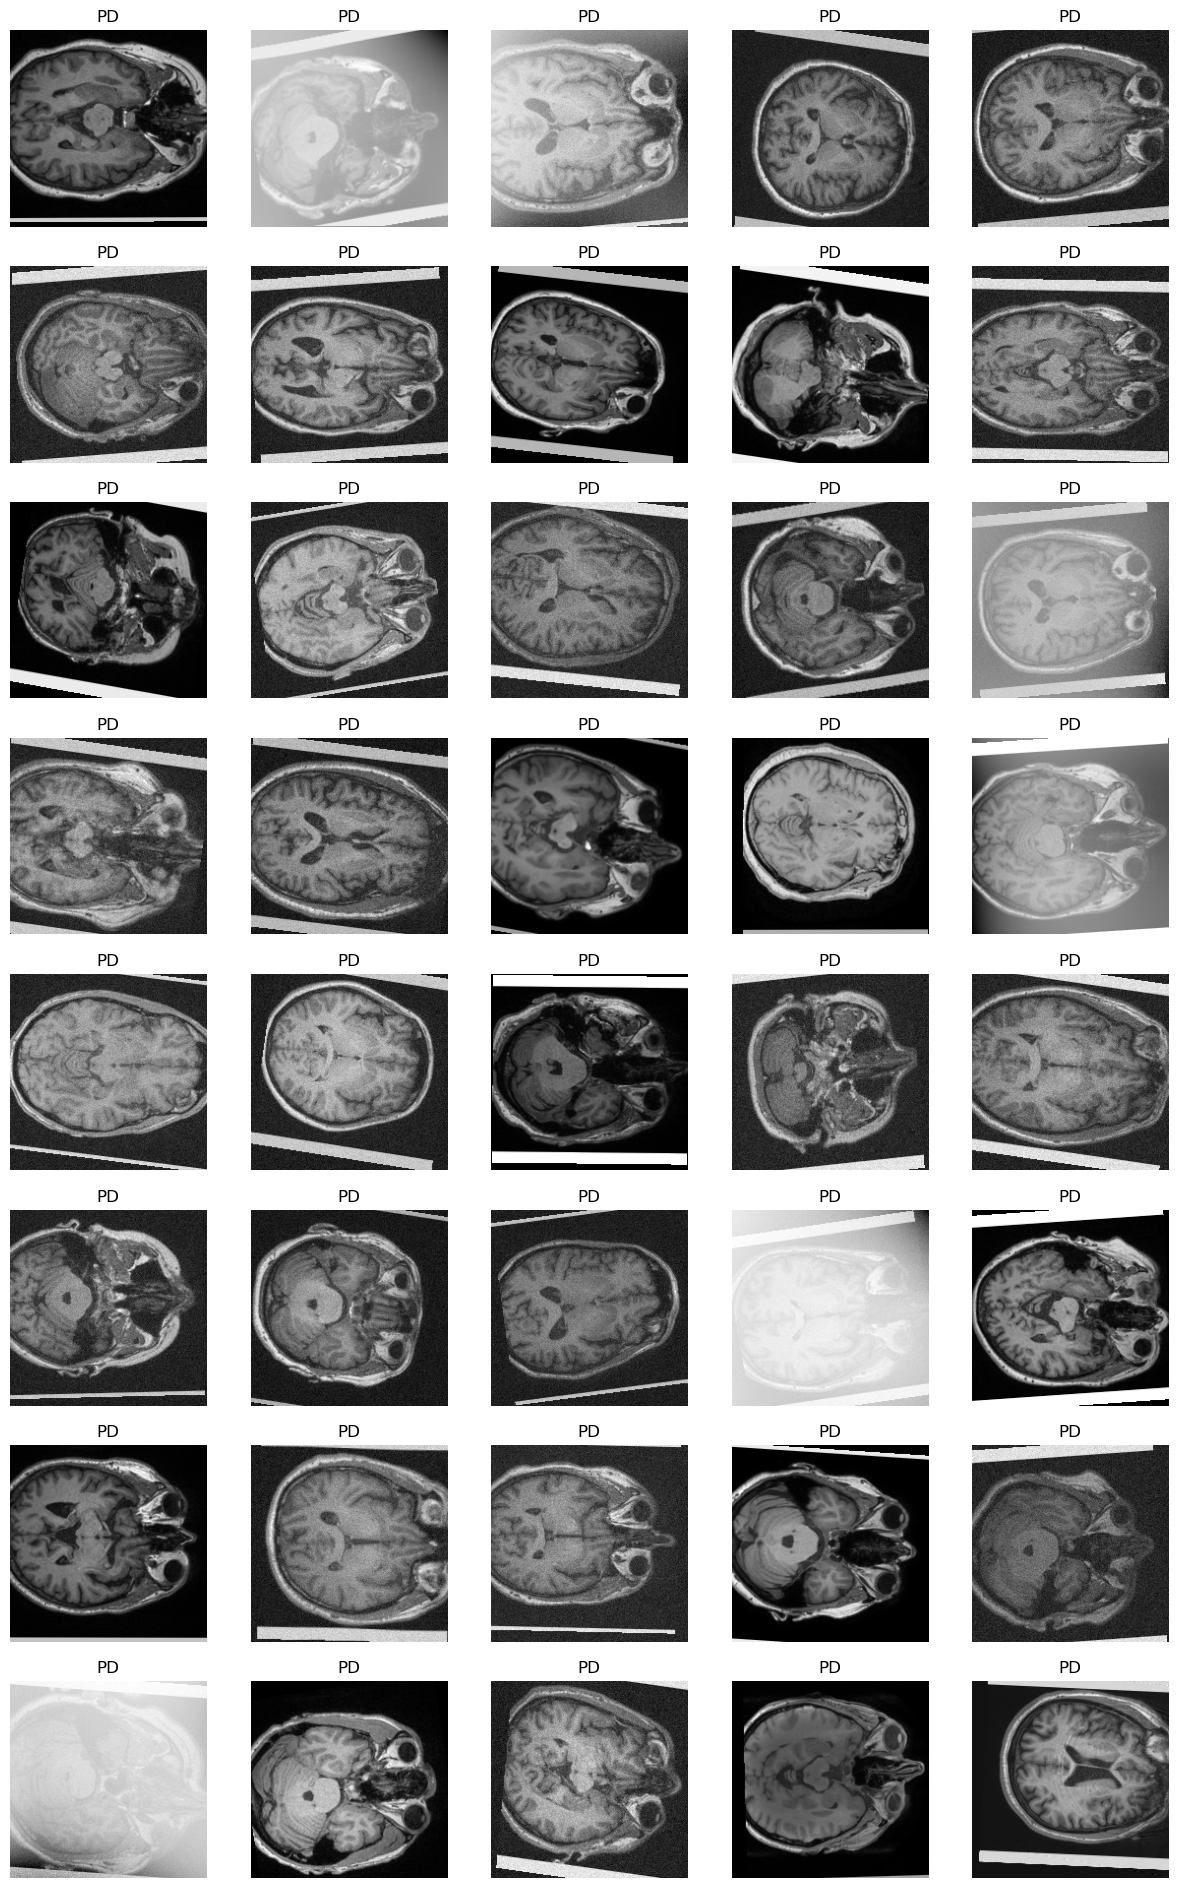

In [10]:
# training subjects
plot_subjects(pd_subjs[:40], 'PD')

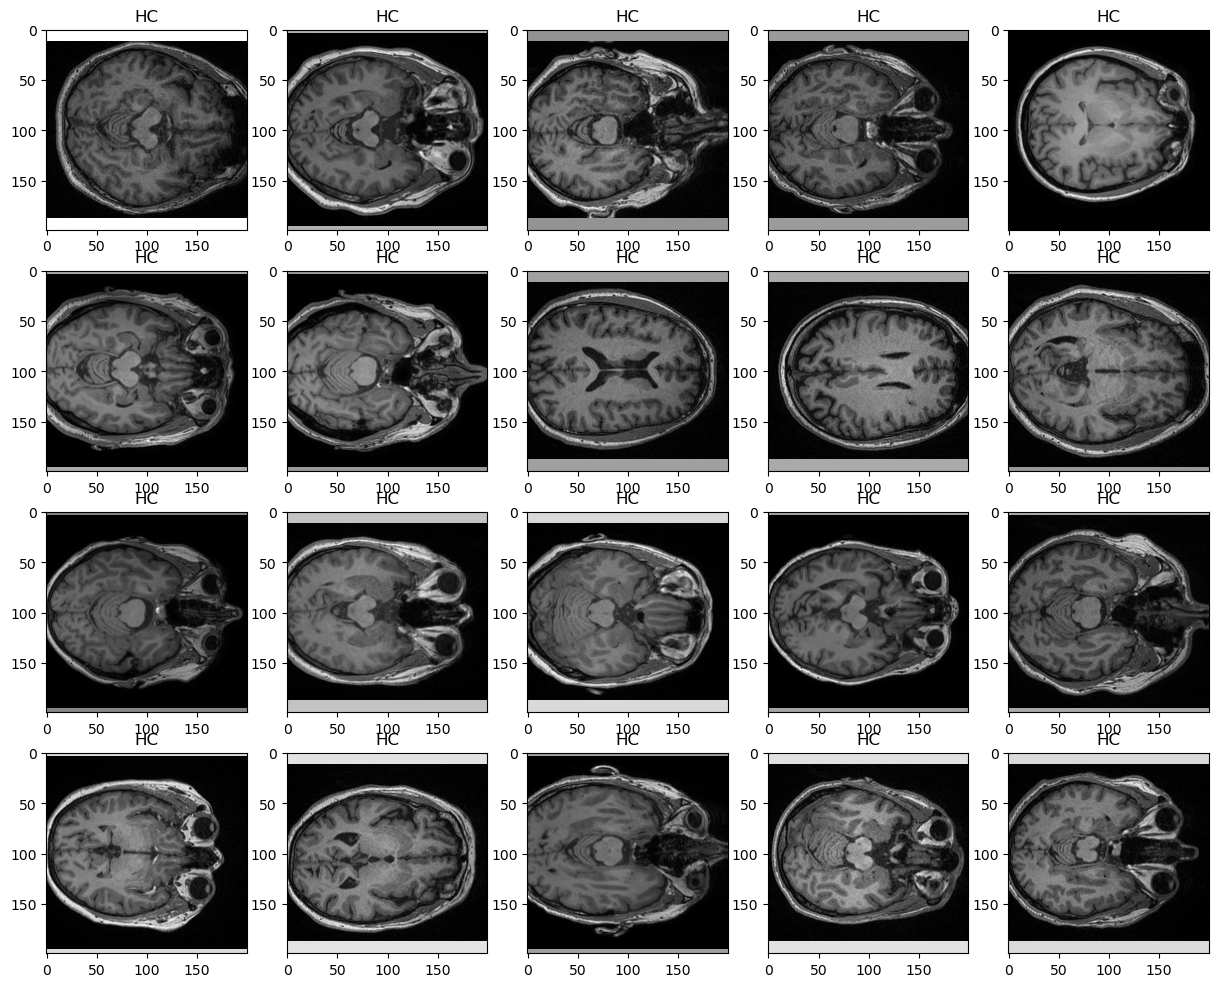

In [23]:
plot_subjects(hc_subjs, 'HC')

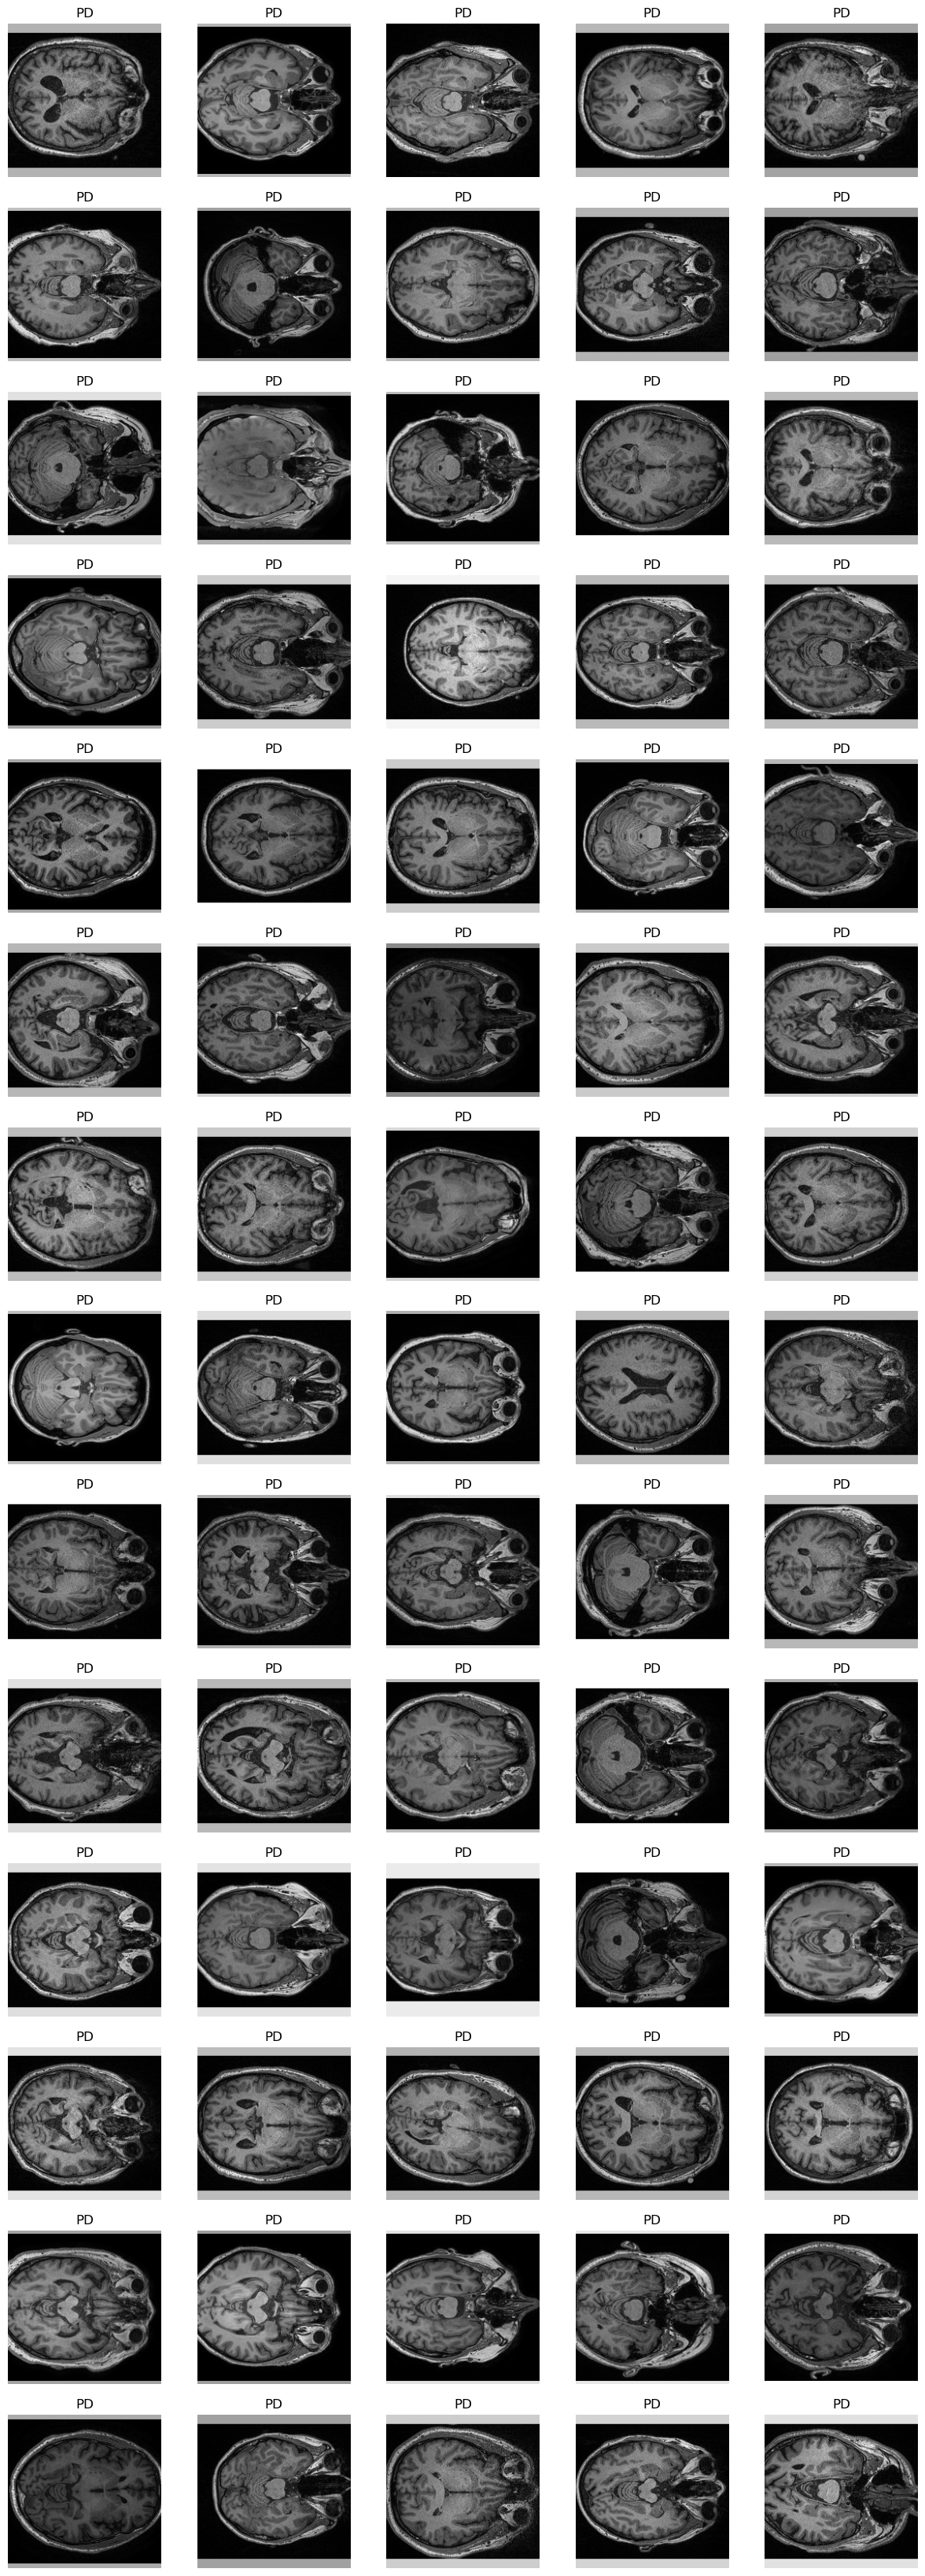

In [25]:
plot_subjects(pd_subjs, 'PD')

In [4]:
cfg['model']['net'] = 'efficient'
model = Model(**cfg['model'])

In [5]:
cfg['dataset']['val_batch_size'] = 10
cfg['dataset']['train_batch_size'] = 10

data_bz10 = PPMIDataModule(md_df=md_df_first, 
                        root_dir=root_dir, 
                        augment=augmentations, 
                        **cfg['dataset'])
data_bz10.prepare_data()
data_bz10.setup()

val_loader = data_bz10.val_dataloader()

for batch in val_loader:
    y_hat, y = model.infer_batch(batch)
    loss = model.criterion(y_hat, y)
    break

In [14]:
print(y_hat.shape, y.shape, loss)
print(y_hat, y)

torch.Size([10, 2]) torch.Size([10, 2]) tensor(1.1018, grad_fn=<DivBackward1>)
tensor([[ 3.9197,  1.8080],
        [ 3.4469,  0.3945],
        [-5.9470, -5.0134],
        [ 1.2269, -2.7114],
        [ 1.5223,  1.4332],
        [ 2.7445, -1.1031],
        [ 2.5929, -0.8392],
        [ 1.4848,  2.3851],
        [ 3.5721,  0.7396],
        [ 0.9128, -1.0772]], grad_fn=<AddmmBackward0>) tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])


In [21]:
import kornia.losses as losses
fl = losses.FocalLoss(0.5)
fl(y_hat, torch.argmax(y, 1))

tensor([6.6684e-04, 4.8394e-05, 3.2595e-01, 5.4271e-06, 1.0074e-01, 6.4582e-06,
        1.6252e+00, 1.4245e-02, 1.2886e+00, 8.1967e-01],
       grad_fn=<ViewBackward0>)

In [13]:
acc = torchmetrics.classification.BinaryAccuracy()
acc(y_hat, y)

tensor(0.5000)

In [7]:
for batch in val_loader:
    inputs = batch['image'][tio.DATA]
    target = batch['label']
    break

print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([10, 1, 200, 200, 200]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([10, 2])


In [16]:
torch.rand(1, 5, 3, 5)

tensor([[[[0.5930, 0.3022, 0.4636, 0.5369, 0.2893],
          [0.4209, 0.7768, 0.7144, 0.2817, 0.2488],
          [0.0135, 0.0750, 0.9071, 0.8898, 0.2097]],

         [[0.9103, 0.2377, 0.1546, 0.7443, 0.6827],
          [0.2010, 0.5549, 0.8290, 0.0642, 0.9315],
          [0.6824, 0.8507, 0.1045, 0.6611, 0.4869]],

         [[0.5258, 0.4436, 0.4353, 0.0932, 0.0295],
          [0.6213, 0.2332, 0.6521, 0.6903, 0.6930],
          [0.9962, 0.0484, 0.2008, 0.4416, 0.2486]],

         [[0.3268, 0.0528, 0.9662, 0.7387, 0.3285],
          [0.6094, 0.0976, 0.8649, 0.5930, 0.7206],
          [0.2076, 0.6834, 0.4502, 0.2582, 0.2549]],

         [[0.2054, 0.7288, 0.2623, 0.4107, 0.8333],
          [0.4661, 0.1449, 0.0207, 0.6794, 0.6708],
          [0.2601, 0.8704, 0.1347, 0.2836, 0.2124]]]])

In [19]:
torch.empty(1, 3, 5, dtype=torch.long).random_(5)

tensor([[[2, 0, 4, 3, 4],
         [4, 4, 3, 3, 4],
         [3, 1, 4, 2, 3]]])